In [1]:
# ===== Notebook 3: Clustering Analysis =====
# Axora: Clinical Document Classification

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import (
    homogeneity_score, completeness_score, v_measure_score,
    adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
)

from collections import Counter
import textwrap
import warnings, os, sys, re, math, random

# Plot aesthetics
sns.set(style="whitegrid", font_scale=1.05)
plt.rcParams["figure.figsize"] = (10, 6)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)

warnings.filterwarnings("ignore")
print("✅ Imports ready.")

c:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Imports ready.


In [2]:
# Load the same dataset used in Notebook 1
dataset = load_dataset("hpe-ai/medical-cases-classification-tutorial")

train_df = pd.DataFrame(dataset["train"])
val_df   = pd.DataFrame(dataset["validation"])
test_df  = pd.DataFrame(dataset["test"])

# Keep only the fields we need
cols = ["transcription", "medical_specialty"]
train_df = train_df[cols].copy()
val_df   = val_df[cols].copy()
test_df  = test_df[cols].copy()

# Combine for unsupervised clustering (we'll still keep true labels for evaluation)
all_df = pd.concat(
    [
        train_df.assign(split="train"),
        val_df.assign(split="val"),
        test_df.assign(split="test"),
    ],
    axis=0,
    ignore_index=True
)

# Basic overview
print("=== Dataset Overview (Notebook 3) ===")
print(f"Total documents: {len(all_df)}")
print(f"  Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}")
print(f"Unique specialties: {all_df['medical_specialty'].nunique()}")
print(all_df["medical_specialty"].value_counts().head())

Repo card metadata block was not found. Setting CardData to empty.


=== Dataset Overview (Notebook 3) ===
Total documents: 2464
  Train: 1724 | Val: 370 | Test: 370
Unique specialties: 13
medical_specialty
Cardiovascular / Pulmonary    742
Orthopedic                    408
Neurology                     282
Gastroenterology              222
Obstetrics / Gynecology       182
Name: count, dtype: int64


In [3]:
# Minimal cleaner for robustness (keep consistent with earlier logic)
def clean_text(text: str) -> str:
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    # keep letters, digits, and spaces; remove boilerplate symbols
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

all_df["text_clean"] = all_df["transcription"].map(clean_text)
print("Sample cleaned text:\n", textwrap.shorten(all_df.iloc[0]["text_clean"], width=200))

Sample cleaned text:
 procedure note pacemaker icd interrogation history of present illness the patient is a 67 year old gentleman who was admitted to the hospital he has had icd pacemaker implantation this is a st [...]


In [4]:
# Match Notebook 1 settings: max_features=5000, english stopwords, ngram_range=(1,2)
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2),
    lowercase=False,   # we already lowercased
    norm="l2"          # default; good for cosine-like behavior with euclidean
)

X_all = vectorizer.fit_transform(all_df["text_clean"])
feature_names = np.array(vectorizer.get_feature_names_out())

print("=== TF-IDF Matrix ===")
print("Shape:", X_all.shape)
print("Features (first 10):", feature_names[:10])

=== TF-IDF Matrix ===
Shape: (2464, 5000)
Features (first 10): ['00' '000' '000 epinephrine' '01' '02' '03' '04' '05' '06' '07']


In [5]:
# k = 13 per spec
K = 13
kmeans = KMeans(
    n_clusters=K,
    random_state=RANDOM_STATE,
    n_init=20,
    max_iter=500,
    verbose=0
)
kmeans.fit(X_all)

cluster_labels = kmeans.labels_
all_df["cluster"] = cluster_labels

print("Cluster sizes:", pd.Series(cluster_labels).value_counts().sort_index().to_dict())

Cluster sizes: {0: 83, 1: 277, 2: 128, 3: 406, 4: 132, 5: 492, 6: 40, 7: 251, 8: 134, 9: 84, 10: 167, 11: 162, 12: 108}


In [6]:
def top_terms_per_cluster(centers, feat_names, topn=15):
    """
    centers: (K, D) array of cluster centroids
    feat_names: np.array of length D with feature names
    """
    top = {}
    for c in range(centers.shape[0]):
        # argsort descending on centroid weights
        idx = np.argsort(-centers[c])[:topn]
        top[c] = list(zip(feat_names[idx], centers[c, idx]))
    return top

# k-means centers live in dense space; ensure ndarray
centers = kmeans.cluster_centers_
cluster_top = top_terms_per_cluster(centers, feature_names, topn=15)

# Pretty print
for c in range(K):
    terms = ", ".join([t for t, _ in cluster_top[c]])
    print(f"[Cluster {c}] Top terms: {terms}")

[Cluster 0] Top terms: c5, c6, c4, c5 c6, cervical, c4 c5, c3, c7, c6 c7, anterior, c3 c4, anterior cervical, disk, disc, plate
[Cluster 1] Top terms: mg, history, patient, daily, mg daily, disease, heart, pain, past, denies, chest, hypertension, atrial fibrillation, fibrillation, atrial
[Cluster 2] Top terms: uterus, placed, incision, uterine, patient, procedure, vicryl, port, fascia, removed, gallbladder, trocar, cervix, suture, adhesions
[Cluster 3] Top terms: patient, procedure, placed, left, right, incision, catheter, anesthesia, tube, using, tumor, used, chest, diagnosis, skin
[Cluster 4] Top terms: unremarkable, revealed, 93, left, exam, right, weakness, 95, 96, mri, 92, cn, sensory, brain, hx
[Cluster 5] Top terms: history, patient, pain, normal, does, past, right, time, left, examination, denies, dr, medical, symptoms, medications
[Cluster 6] Top terms: valve, aortic, mitral, normal, aortic valve, regurgitation, tricuspid, left, atrium, mild, ventricle, doppler, ventricular, f

In [7]:
# Crosstab for inspecting alignment between unsupervised clusters and actual specialties
ct = pd.crosstab(all_df["cluster"], all_df["medical_specialty"]).sort_index()
ct_total = ct.sum(axis=1)
ct_pct = (ct.T / ct.sum(axis=1)).T  # row-normalized

print("=== Cluster vs Specialty (counts) ===")
display(ct)

print("=== Cluster vs Specialty (row % normalized) ===")
display(ct_pct.style.format("{:.2%}"))

=== Cluster vs Specialty (counts) ===


medical_specialty,Cardiovascular / Pulmonary,ENT - Otolaryngology,Gastroenterology,Hematology - Oncology,Nephrology,Neurology,Neurosurgery,Obstetrics / Gynecology,Ophthalmology,Orthopedic,Pediatrics - Neonatal,Psychiatry / Psychology,Radiology
cluster,,,,,,,,,,,,,
0,0,0,0,0,0,2,39,0,0,42,0,0,0
1,150,0,25,25,29,10,0,8,0,10,0,20,0
2,4,0,34,1,5,0,0,84,0,0,0,0,0
3,176,46,24,29,11,19,41,13,10,37,0,0,0
4,2,0,0,0,0,85,0,0,0,17,0,0,28
5,50,12,49,60,9,122,5,35,15,83,4,46,2
6,38,0,0,0,0,0,0,0,0,0,0,0,2
7,4,0,0,2,0,6,22,0,41,176,0,0,0
8,20,1,18,1,11,32,0,5,0,42,0,0,4


=== Cluster vs Specialty (row % normalized) ===


medical_specialty,Cardiovascular / Pulmonary,ENT - Otolaryngology,Gastroenterology,Hematology - Oncology,Nephrology,Neurology,Neurosurgery,Obstetrics / Gynecology,Ophthalmology,Orthopedic,Pediatrics - Neonatal,Psychiatry / Psychology,Radiology
cluster,,,,,,,,,,,,,
0,0.00%,0.00%,0.00%,0.00%,0.00%,2.41%,46.99%,0.00%,0.00%,50.60%,0.00%,0.00%,0.00%
1,54.15%,0.00%,9.03%,9.03%,10.47%,3.61%,0.00%,2.89%,0.00%,3.61%,0.00%,7.22%,0.00%
2,3.12%,0.00%,26.56%,0.78%,3.91%,0.00%,0.00%,65.62%,0.00%,0.00%,0.00%,0.00%,0.00%
3,43.35%,11.33%,5.91%,7.14%,2.71%,4.68%,10.10%,3.20%,2.46%,9.11%,0.00%,0.00%,0.00%
4,1.52%,0.00%,0.00%,0.00%,0.00%,64.39%,0.00%,0.00%,0.00%,12.88%,0.00%,0.00%,21.21%
5,10.16%,2.44%,9.96%,12.20%,1.83%,24.80%,1.02%,7.11%,3.05%,16.87%,0.81%,9.35%,0.41%
6,95.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,5.00%
7,1.59%,0.00%,0.00%,0.80%,0.00%,2.39%,8.76%,0.00%,16.33%,70.12%,0.00%,0.00%,0.00%
8,14.93%,0.75%,13.43%,0.75%,8.21%,23.88%,0.00%,3.73%,0.00%,31.34%,0.00%,0.00%,2.99%


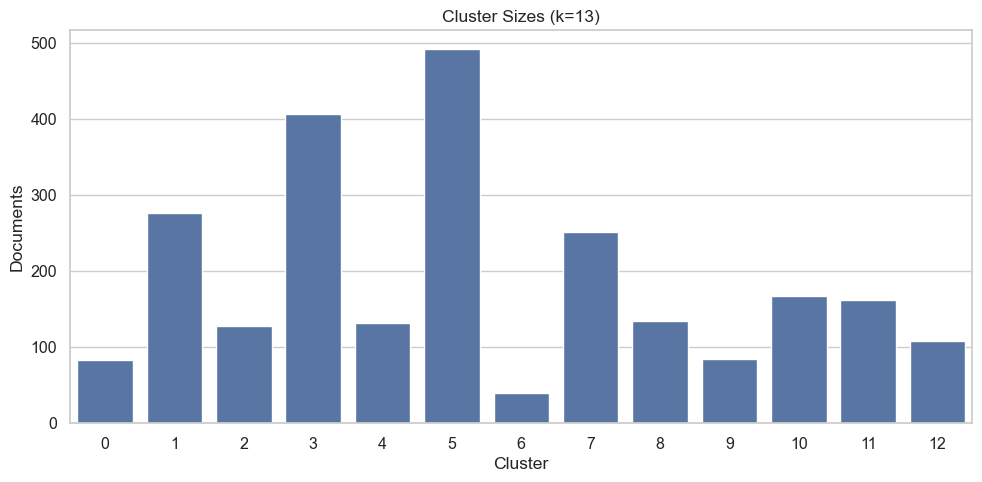

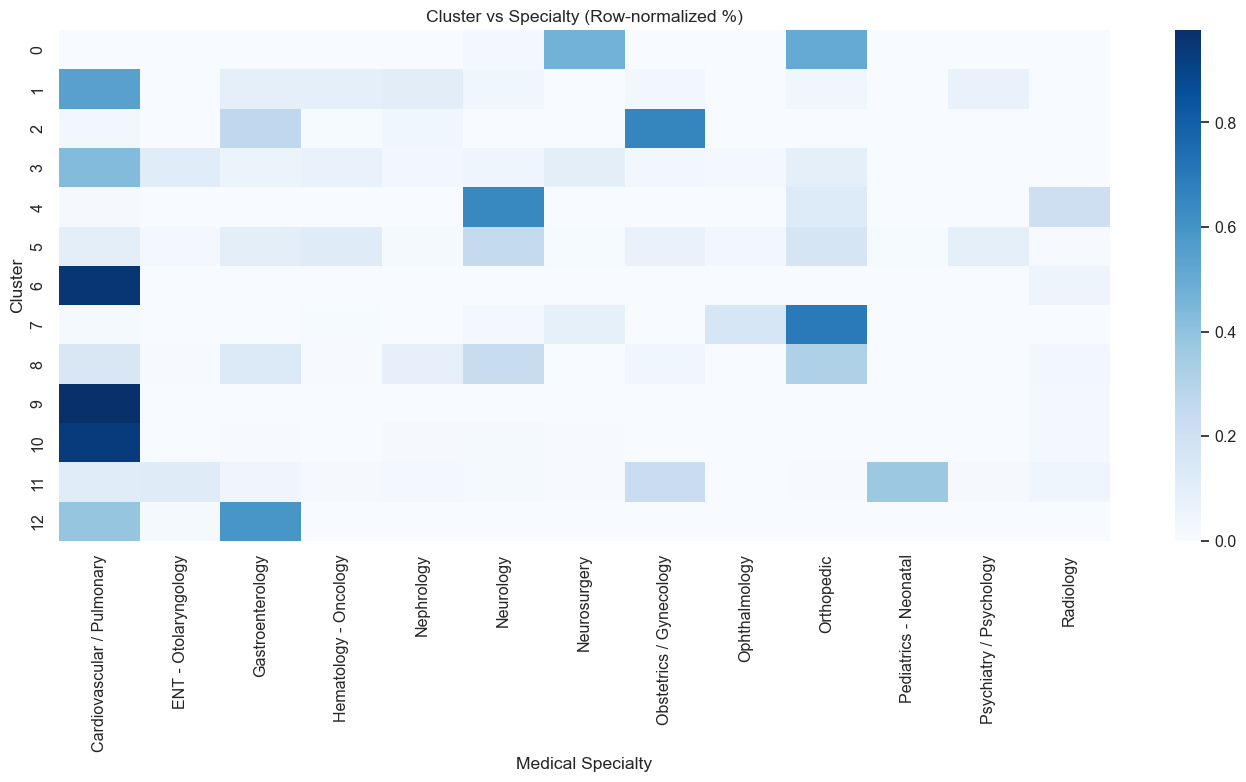

In [8]:
# Bar chart: cluster sizes
sizes = all_df["cluster"].value_counts().sort_index()
plt.figure(figsize=(10, 5))
sns.barplot(x=sizes.index, y=sizes.values)
plt.title("Cluster Sizes (k=13)")
plt.xlabel("Cluster")
plt.ylabel("Documents")
plt.tight_layout()
plt.show()

# Heatmap: top specialties per cluster (row-normalized)
plt.figure(figsize=(14, 8))
sns.heatmap(ct_pct, annot=False, cmap="Blues")
plt.title("Cluster vs Specialty (Row-normalized %)")
plt.xlabel("Medical Specialty")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

In [9]:
# External clustering metrics (use true labels only for evaluation/interpretation)
y_true = all_df["medical_specialty"].values

homog = homogeneity_score(y_true, cluster_labels)
compl = completeness_score(y_true, cluster_labels)
vmeas = v_measure_score(y_true, cluster_labels)
ari  = adjusted_rand_score(y_true, cluster_labels)
ami  = adjusted_mutual_info_score(y_true, cluster_labels)

# Silhouette (euclidean on l2-normalized tf-idf approximates cosine silhouette)
# For very large corpora, subsample to speed up:
if X_all.shape[0] > 5000:
    idx = np.random.choice(X_all.shape[0], 5000, replace=False)
    sil = silhouette_score(X_all[idx], cluster_labels[idx], metric="euclidean")
else:
    sil = silhouette_score(X_all, cluster_labels, metric="euclidean")

print("=== Cluster Quality Metrics ===")
print(f"Homogeneity:   {homog:.3f}")
print(f"Completeness:  {compl:.3f}")
print(f"V-Measure:     {vmeas:.3f}")
print(f"ARI:           {ari:.3f}")
print(f"AMI:           {ami:.3f}")
print(f"Silhouette:    {sil:.3f}")

=== Cluster Quality Metrics ===
Homogeneity:   0.356
Completeness:  0.329
V-Measure:     0.342
ARI:           0.132
AMI:           0.333
Silhouette:    0.036


In [10]:
# Find dominant specialty per cluster and purity (% of that specialty in the cluster)
dominants = []
for c in range(K):
    counts = ct.loc[c]
    top_spec = counts.idxmax()
    purity = (counts.max() / counts.sum()) if counts.sum() > 0 else 0.0
    dominants.append((c, top_spec, purity, int(counts.sum())))

dominants_df = pd.DataFrame(dominants, columns=["cluster", "dominant_specialty", "purity", "size"])\
                 .sort_values(by="purity", ascending=False)

print("=== Dominant Specialty per Cluster ===")
display(dominants_df.style.format({"purity": "{:.1%}"}))

=== Dominant Specialty per Cluster ===


,cluster,dominant_specialty,purity,size
9,9,Cardiovascular / Pulmonary,97.6%,84
6,6,Cardiovascular / Pulmonary,95.0%,40
10,10,Cardiovascular / Pulmonary,93.4%,167
7,7,Orthopedic,70.1%,251
2,2,Obstetrics / Gynecology,65.6%,128
4,4,Neurology,64.4%,132
12,12,Gastroenterology,59.3%,108
1,1,Cardiovascular / Pulmonary,54.2%,277
0,0,Orthopedic,50.6%,83
3,3,Cardiovascular / Pulmonary,43.3%,406


In [11]:
# Build a compact summary table
rows = []
for c in range(K):
    terms = [t for t, _ in cluster_top[c][:10]]
    top_specs = ct.loc[c].sort_values(ascending=False).head(3)
    rows.append({
        "cluster": c,
        "size": int(ct.loc[c].sum()),
        "top_terms": ", ".join(terms),
        "top_specialties": ", ".join([f"{k} ({v})" for k, v in top_specs.items()])
    })

summary_df = pd.DataFrame(rows).sort_values(by="size", ascending=False)
print("=== Cluster Summary (Top Terms & Specialties) ===")
display(summary_df)

=== Cluster Summary (Top Terms & Specialties) ===


,cluster,size,top_terms,top_specialties
5,5,492,"history, patient, pain, normal, does, past, ri...","Neurology (122), Orthopedic (83), Hematology -..."
3,3,406,"patient, procedure, placed, left, right, incis...","Cardiovascular / Pulmonary (176), ENT - Otolar..."
1,1,277,"mg, history, patient, daily, mg daily, disease...","Cardiovascular / Pulmonary (150), Nephrology (..."
7,7,251,"patient, placed, eye, l5, knee, procedure, fra...","Orthopedic (176), Ophthalmology (41), Neurosur..."
10,10,167,"artery, coronary, left, coronary artery, right...","Cardiovascular / Pulmonary (156), Radiology (4..."
11,11,162,"fetal, history, normal, mom, child, patient, e...","Pediatrics - Neonatal (60), Obstetrics / Gynec..."
8,8,134,"ct, contrast, normal, tendon, exam, images, fi...","Orthopedic (42), Neurology (32), Cardiovascula..."
4,4,132,"unremarkable, revealed, 93, left, exam, right,...","Neurology (85), Radiology (28), Orthopedic (17)"
2,2,128,"uterus, placed, incision, uterine, patient, pr...","Obstetrics / Gynecology (84), Gastroenterology..."
12,12,108,"scope, procedure, colon, bronchoscope, lobe, p...","Gastroenterology (64), Cardiovascular / Pulmon..."


In [ ]:
# Exports to help with the report/dashboards
os.makedirs("artifacts_clustering", exist_ok=True)
summary_df.to_csv("artifacts_clustering/cluster_summary.csv", index=False)
ct.to_csv("artifacts_clustering/cluster_vs_specialty_counts.csv")
ct_pct.to_csv("artifacts_clustering/cluster_vs_specialty_rowpct.csv")

# Document-level mapping
doc_map = all_df[["split", "medical_specialty", "cluster"]].copy()
doc_map.to_csv("artifacts_clustering/document_cluster_map.csv", index=False)

print("✅ Exported:")
print("- artifacts_clustering/cluster_summary.csv")
print("- artifacts_clustering/cluster_vs_specialty_counts.csv")
print("- artifacts_clustering/cluster_vs_specialty_rowpct.csv")
print("- artifacts_clustering/document_cluster_map.csv")

In [ ]:
# Heuristic insights based on purity and overlap
lines = []
lines.append("=== CLUSTERING INSIGHTS (Auto-Generated) ===\n")

# 1) Clear clusters (high purity)
clear_clusters = dominants_df[dominants_df["purity"] >= 0.6]
if not clear_clusters.empty:
    lines.append("1) Strong, well-separated themes (purity ≥ 60%):")
    for _, row in clear_clusters.iterrows():
        c = int(row["cluster"])
        lines.append(f"   • Cluster {c}: Dominant = {row['dominant_specialty']} "
                     f"(purity {row['purity']:.0%}, size {row['size']}). "
                     f"Top terms: {', '.join([t for t, _ in cluster_top[c][:6]])}")
else:
    lines.append("1) No clusters exceeded 60% purity; themes are more blended across specialties.")

# 2) Mixed clusters (moderate purity)
mixed = dominants_df[(dominants_df["purity"] < 0.6) & (dominants_df["purity"] >= 0.4)]
if not mixed.empty:
    lines.append("\n2) Mixed/overlapping themes (purity 40–60%):")
    for _, row in mixed.iterrows():
        c = int(row["cluster"])
        top3 = ct.loc[c].sort_values(ascending=False).head(3)
        specs = ", ".join([f"{k} ({v})" for k, v in top3.items()])
        lines.append(f"   • Cluster {c}: Mix of {specs}. "
                     f"Terms suggest: {', '.join([t for t, _ in cluster_top[c][:5]])}")

# 3) Highly mixed clusters (low purity)
low = dominants_df[dominants_df["purity"] < 0.4]
if not low.empty:
    lines.append("\n3) Broad/general clusters (purity < 40%):")
    for _, row in low.iterrows():
        c = int(row["cluster"])
        lines.append(f"   • Cluster {c}: Broad theme; consider sub-clustering or domain lexicons. "
                     f"Indicative terms: {', '.join([t for t, _ in cluster_top[c][:5]])}")

# 4) Business value suggestions
lines.append("\n4) Business Value:")
lines.append("   • Identify documentation archetypes for QA templates and auto-triage.")
lines.append("   • Surface cluster keywords in search/filters within Axora MedArchive.")
lines.append("   • For mixed clusters, add guided tags (e.g., ‘pre-op note’, ‘post-op summary’).")
lines.append("   • Use clusters to recommend specialty routing when supervised scores are borderline.")

print("\n".join(lines))

In [ ]:
print("=== SUMMARY ===")
print(f"- Ran k-Means with k={K} on TF-IDF (shape {X_all.shape}).")
print("- Extracted top terms per cluster and built cluster↔specialty crosstabs.")
print("- Reported homogeneity/completeness/V-measure, ARI/AMI, and silhouette.")
print("- Generated visuals (cluster sizes + heatmap) and exported CSV artifacts.")
print("🎉 Clustering analysis complete — ready to integrate insights into the report.")
